#### Group-Wise Distance Metrics Learner: Experiment 02
* data resouce: simulation data genearted by Dr.Huang
* no. of users:
* no. of features:
* social structure

In [2]:
import os

import scipy as sp
import numpy as np
import pandas as pd
import sklearn as sk
import networkx as nx

from matplotlib import pyplot as plt
from learning_dist_metrics import LDM

%matplotlib inline

In [3]:
!dir data

 Volume in drive C is SYSTEM
 Volume Serial Number is 1408-98AC

 Directory of C:\Z_personal_doc\phd_experiment\data

06/28/2015  04:40 PM    <DIR>          .
06/28/2015  04:40 PM    <DIR>          ..
06/27/2015  08:19 PM            44,043 drhuang_artificial_data_1.xlsx
06/28/2015  04:40 PM            20,686 drhuang_friend.csv
06/28/2015  04:40 PM             2,023 drhuang_person.csv
06/27/2015  08:19 PM    <DIR>          sim_data_yi
               3 File(s)         66,752 bytes
               3 Dir(s)  132,379,353,088 bytes free


In [4]:
user_df = pd.read_csv("data/drhuang_person.csv", header=0)
friend_df = pd.read_csv("data/drhuang_friend.csv", header=0,)

In [36]:
print user_df.describe()

uid_df = user_df["ID"]
profile_df = user_df
#profile_df = user_df[[c for c in user_df.columns if c != "ID"]]

print friend_df

               ID     Gender          Age      Region   Education      Income  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    50.500000    0.490000   56.540000    2.320000    2.070000    2.920000   
std     29.011492    0.502418   22.060715    1.581969    1.112418    1.750498   
min      1.000000    0.000000   19.000000    0.000000    0.000000    0.000000   
25%     25.750000    0.000000   37.000000    1.000000    1.000000    2.000000   
50%     50.500000    0.000000   58.000000    2.000000    2.000000    3.000000   
75%     75.250000    1.000000   75.000000    4.000000    3.000000    4.000000   
max    100.000000    1.000000   97.000000    5.000000    4.000000    6.000000   

            Hobby    Duration  
count  100.000000  100.000000  
mean     3.970000   24.510000  
std      2.066838   15.194028  
min      0.000000    0.000000  
25%      2.000000   10.000000  
50%      4.000000   25.000000  
75%      6.000000   38.000000  
max      7.000

In [45]:
print uid_df

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
...
85     86
86     87
87     88
88     89
89     90
90     91
91     92
92     93
93     94
94     95
95     96
96     97
97     98
98     99
99    100
Name: ID, Length: 100, dtype: int64


In [46]:
friend_df.head(3)
#friend_df.columns = [""range(0, friend_df.shape[1]-1)
relation_mtx = friend_df.ix[:, 1:]
relation_mtx.head(4)

friend_pairs = []
uid_row = uid_df
uid_col = uid_row

# convert relationship matrix into a list of user pairs
# to represent friendships, iterating through items
# on the lower triangle of the matrix
for i, uid_a in enumerate(uid_row):
    for j, uid_b in enumerate(uid_col):

        if i < j:
            ind = relation_mtx.ix[i, j]
            if ind == 1:
                uid_min = min([uid_a, uid_b])
                uid_max = max([uid_a, uid_b])
                friend_pairs.append((uid_min, uid_max))

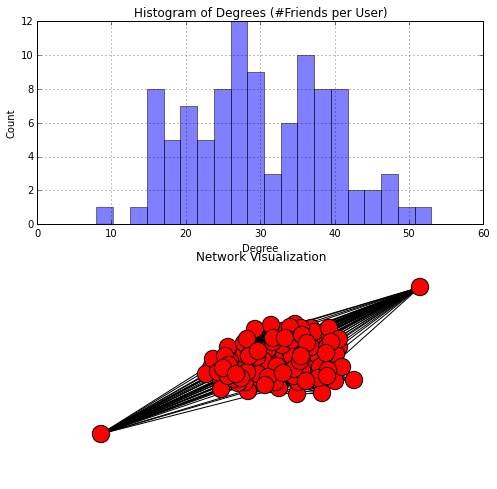

In [90]:
# load relationship into networkx.Graph()
from networkx import Graph

friends_nx = Graph()
friends_nx.add_edges_from(friend_pairs)

# examine the relationship
# summarize the structure
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
pd.Series(fnx.degree().values()).hist(alpha=0.5, bins=20)
plt.title("Histogram of Degrees (#Friends per User)")
plt.xlabel("Degree")
plt.ylabel("Count")


# visualize social network
plt.subplot(2, 1, 2)
nx.draw(friends_nx, pos=nx.spring_layout(fnx))
plt.title("Network Visualization")

plt.show()

### Data Manipulation
* *user_df*: feature-wise normalization
* *friend_df*:
    * strategy 01: feature-wise normalization

In [38]:
def scalar(x):
    _min, _max = min(x), max(x)
    _range = (_max - _min) * 1.0
    res = [(i - _min) / _range for i in x]
    return res

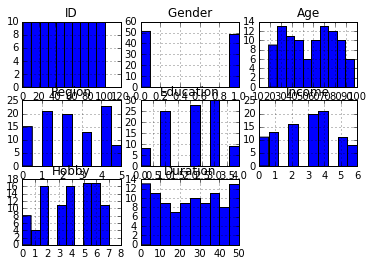

In [39]:
plt.figure()

for i, c in enumerate(profile_df.columns, 1):

    plt.subplot(3, 3, i)
    profile_df[c].hist()
    plt.title("%s" % c)

plt.show()

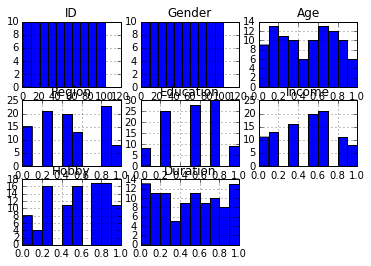

In [43]:
new_profile_df = pd.DataFrame()

new_profile_df["ID"]        = profile_df["ID"].copy()
new_profile_df["Gender"]    = profile_df.ix[:, 0]
new_profile_df["Age"]       = scalar(profile_df["Age"])
new_profile_df["Region"]    = scalar(profile_df["Region"])
new_profile_df["Education"] = scalar(profile_df["Education"])
new_profile_df["Income"]    = scalar(profile_df["Income"])
new_profile_df["Hobby"]     = scalar(profile_df["Hobby"])
new_profile_df["Duration"]  = scalar(profile_df["Duration"])

plt.figure()

for i, c in enumerate(new_profile_df.columns, 1):

    plt.subplot(3, 3, i)
    new_profile_df[c].hist()
    plt.title("%s" % c)

plt.show()

#### Apply the learning algorithm to data

In [93]:
from scipy.stats import rayleigh
from scipy.stats import ks_2samp
from numpy import linspace
from numpy.random import choice
from networkx import Graph

from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.dist_metrics import weighted_euclidean

from GWDLearner import *

In [13]:
def group_composite(user_id, users_df):
    """ Summarize the emember's belongings
    """
    
    if len(user_id) > 0:
        is_row = [i_id in user_id for i_id in users_df.ID]
        num_g0 = sum(users_df.ix[is_row, "decision_style"] == 0)
        num_g1 = sum(users_df.ix[is_row, "decision_style"] == 1)
        ptg_g0 = round(num_g0 / float(len(user_id)), 2)
        ptg_g1 = round(num_g1 / float(len(user_id)), 2)
    else: 
        ptg_g0, ptg_g1 = 0, 0
        
    return (ptg_g0, ptg_g1)

In [60]:
users_df = user_df
all_user_ids = list(set(users_df.ID))
new_profile_df["ID"] = user_df.ID

ldm = LDM()
ldm.fit(new_profile_df, friend_pairs)

print ldm.get_transform_matrix()
print ldm.get_ratio()

--- 179.69 seconds ---


In [97]:
import scipy as sp
import numpy as np
import pandas as pd

from scipy.stats import rayleigh
from scipy.stats import ks_2samp
from numpy import linspace
from numpy.random import choice
from networkx import Graph
from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.dist_metrics import weighted_euclidean


def user_grouped_dist(user_id, weights, profile_df, friends_networkx):
    """ Calculate distances between a user and whose friends
        and distance between a user and whose non-friends.
        The groupped distance vector will be output.

    Parameters:
    ----------
    * user_id: {integer}, the target user's ID
    * weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    * friends_networkx: {networkx.Graph()}, Graph() object from Networkx
        to store the relationships informat
    Returns:
    -------
    res: {list, list of integers}, a list of two lists, which store the distances
        of either friends and non-friends separately.

    Examples:
    ---------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[ ["ID"] + cols ]
    user_dist = user_grouped_dist(user_id = 0, weights = weights
        , profile_df, friends_df)
    print user_dist["friends"]
    print user_dist["nonfriends"]
    """
    cols = [col for col in profile_df.columns if col is not "ID"]
    # get the user profile information of the target users
    user_profile = profile_df.ix[profile_df.ID == user_id, cols].as_matrix()
    # get the user_id of friends of the target user
    friends_ls = friends_networkx.neighbors(user_id)
    all_ids = profile_df.ID
    non_friends_ls = [u for u in all_ids if u not in friends_ls + [user_id]]

    sim_dist_vec = []
    for f_id in friends_ls:
        friend_profile = profile_df.ix[profile_df.ID == f_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, friend_profile, weights)
        sim_dist_vec.append(the_dist)

    diff_dist_vec = []
    for nf_id in non_friends_ls:
        nonfriend_profile = profile_df.ix[profile_df.ID == nf_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, nonfriend_profile, weights)
        diff_dist_vec.append(the_dist)

    res = [sim_dist_vec, diff_dist_vec]
    return res


def user_dist_kstest(sim_dist_vec, diff_dist_vec,
                     fit_rayleigh=False, _n=100):

    """ Test the goodness of a given weights to defferentiate friend distance
        distributions and non-friend distance distributions of a given user.
        The distance distribution is considered to follow Rayleigh distribution.

    Parameters:
    ----------
    sim_dist_vec: {vector-like (list), float}, distances between friends
                  and the user
    diff_dist_vec: {vector-like (list), float}, distances between non-fri
                   -ends and the user
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution

    Returns:
    -------
    * res: {float}: p-value of ks-test with assumption that distances follow
            Rayleigh distribution.

    Examples:
    ---------
    pval = user_dist_kstest(sim_dist_vec, diff_dist_vec)
    """
    # is_valid = (len(sim_dist_vec) >= min_nobs) & \
    #           (len(diff_dist_vec) >= min_nobs) # not used yet
    if fit_rayleigh:
        friend_param = rayleigh.fit(sim_dist_vec)
        nonfriend_param = rayleigh.fit(diff_dist_vec)

        samp_friend = rayleigh.rvs(friend_param[0], friend_param[1], _n)
        samp_nonfriend = rayleigh.rvs(nonfriend_param[0], nonfriend_param[1], _n)

        # ouput p-value of ks-test
        res = ks_2samp(samp_friend, samp_nonfriend)[1]
    else:
        res = ks_2samp(sim_dist_vec, diff_dist_vec)[1]
		
    return res


def users_filter_by_weights(weights, profile_df, friends_networkx,
                            pval_threshold=0.5, 
                            mutate_rate=0.4,
                            min_friend_cnt=10, 
                            users_list=None,
                            fit_rayleigh=False, 
                            _n=1000,
                            is_debug=False):
    """ Split users into two groups, "keep" and "mutate", with respect to
        p-value of the ks-test on the null hypothesis that the distribution of
        friends' weighted distance is not significantly different from the
        couterpart for non-friends. Assume the weighted distances of each group
        follow Rayleigh distribution.

    Parameters:
    ----------
    weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends_networkx: {networkx.Graph()}, Graph() object from Networkx to store
        the relationships information
    pval_threshold: {float}, the threshold for p-value to reject hypothesis
    min_friend_cnt: {integer}, drop users whose total of friends is less than
       this minimum count
    mutate_rate: {float}, a float value [0 - 1] determine the percentage of
       bad_fits member sent to mutation
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution
    is_debug: {boolean}, to control if it yeilds by-product information

    Returns:
    -------
    res: {list} grouped list of user ids
        res[0] stores all users whose null hypothesis does not holds;
        res[1] stores all users whose null hypothesis hold null hypothesis,
        given weights, distance distribution of all friends is significantly
        different from distance distribution of all non-friends

    Examples:
    --------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[["ID"] + cols]
    grouped_users = users_filter_by_weights(weights,
                       profile_df, friends_df, pval_threshold = 0.10,
                       min_friend_cnt = 10)

    Notes:
    -----
    min_friend_cnt is not implemented
    """
    # all_users_ids = list(set(profile_df.ID))
    # users_list
    # container for users meeting different critiria
    pvals = []
    if users_list is None:
        users_list = list(profile_df.ix[:, 0])

    for uid in users_list:
        res_dists = user_grouped_dist(uid, weights, profile_df, friends_networkx)
        pval = user_dist_kstest(res_dists[0], res_dists[1], fit_rayleigh, _n)
        pvals.append(pval)

    sorted_id_pval = sorted(zip(users_list, pvals), key=lambda x: x[1])
    good_fits = [i for i, p in sorted_id_pval if p < pval_threshold]
    bad_fits = [i for i, p in sorted_id_pval if p >= pval_threshold]
    
    if len(bad_fits) > 0:
        mutate_size = np.ceil(len(bad_fits) * mutate_rate)
        mutate_size = max(int(mutate_size), 1)
        id_retain = good_fits + bad_fits[mutate_size:]
        id_mutate = bad_fits[:mutate_size]
    else:
        id_retain = good_fits
        id_mutate = bad_fits
        
    if is_debug is True:
        res = [id_retain, id_mutate, sorted_id_pval]
    else:
        res = [id_retain, id_mutate]
    return res


def ldm_train_with_list(users_list, profile_df, friends, retain_type=1):
    """ learning distance matrics with ldm() instance, provided with selected
        list of users.

    Parameters:
    -----------
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends: {list of tuple}, each tuple keeps a pair of user id
    retain_type: {integer}, 0, adopting 'or' logic by keeping relationship in
        friends_df if either of entities is in user_list 1, adopting 'and'
        logic

    Returns:
    -------
    res: {vector-like, float}, output of ldm.get_transform_matrix()

    Examples:
    ---------
    new_dist_metrics = ldm_train_with_list(user_list, profile_df, friends_df)
    """
    if retain_type == 0:
        friends = [(a, b) for a, b in friends if \
            a in users_list or b in users_list]
    else:
        friends = [(a, b) for a, b in friends if \
            a in users_list and b in users_list]
    
    ldm = LDM()    
    ldm.fit(profile_df, friends)
    weight_vec = ldm.get_transform_matrix()
    return weight_vec     


def hyper_parameter_tester(weights_a, weights_b, fit_rayleigh, num):
    
    """
    """
    
    num_friends = []
    num_nonfriends = []
    ks_pvals_right = []
    ks_pvals_wrong = []

    for uid in tg0_ids: 
        # Compare the distribution of a user's distances of all of his/her friends
        # against the distribuiton of a users's distances of all of his/her non-friends,
        # The collection of non-friends may include those users of two categories with
        # respect to their relationships to the target user: 
        # a. the users who are not likened by the target users 
        # b. the users who are likely to be befriended by the users however
        #    the users do not have a change to be exposed to her/him.
        sim_dists, diff_dists = user_grouped_dist(uid, weights_a, profile_df, fnx)
        pval = user_dist_kstest(sim_dists, diff_dists, fit_rayleigh=fit_rayleigh, _n = num)
        ks_pvals_right.append(pval)
    
        sim_dists, diff_dists = user_grouped_dist(uid, weights_b, profile_df, fnx)
        pval = user_dist_kstest(sim_dists, diff_dists, fit_rayleigh=fit_rayleigh, _n = num)
        ks_pvals_wrong.append(pval)
    
        num_friends.append(len(sim_dists))
        num_nonfriends.append(len(diff_dists))
    
    res_report = pd.DataFrame({"ID": tg0_ids, 
                               "num_friends": num_friends, 
                               "num_nonfriends": num_nonfriends, 
                               "true_pval": ks_pvals_right,
                               "wrong_pval": ks_pvals_wrong})
   
    return res_report

In [99]:
import time

# ------ input parameter processing ------ #
# a. Graph() object store pair-wise relationships
# b. 

# friends_nx = Graph()
# friends_nx.add_nodes_from(list(set(users_df.ID)))

# for a, b in friends_df.pair:
#    friends_nx.add_edge(a, b)

# ------ argument definition ---- #
PVAL = 0.3
# retain type
retain_type = 1
# the percentage of entity whose p-value is
# too large would be returned in res[1] 
mutate_rate = 1 
# True, use rayleigh distribution in KS-test
is_distr_fit = True
# the number of sample withdrawn from the fitted
# rayleigh distribution for KS-test
samp_num = 2000
# stop condition
max_iter= 100

# --- algorithm monitor ------
timer = []
loop_indexes = []
weights_a_collector = []
weights_b_collector = []
cnr_a_size = []
cnr_b_size = []
cnr_c_size = []

cnr_a_members = []
cnr_b_members = []
cnr_c_members = []

cnr_a_learns_collector = []
cnr_b_learns_collector = []
cnr_a_c_learns_collector = []
cnr_b_c_learns_collector = []


# ------ initiation ----- #
np.random.seed(1234)

cnr_a = []
cnr_b = []
cnr_c = []


timer.append(time.time())
# ------ step 01 ------------ #
# training the initial distance weights by learning through the
# complete user base.
print "* ------ initial learning -------- *"
all_user_ids = list(set(users_df.ID))
init_weights = ldm_train_with_list(all_user_ids, new_profile_df, friend_pairs, 
                                   retain_type)
print "initial weights: %s" % init_weights
timer.append(time.time())

# ----- step 02 ------------ #
# evalute each user with learned distance weights from
# previous step. Based on pvalue of ks-test, users with
# non-significant evidance for null hypothesis will be
# put in container b (not expalined by the distance wei
# -ghts. The null hypothesis stated that the disttribut
# -ion of between-friends distance is no different than 
# the couterpart of between-non-friends distance. Provi
# -ded with sizable p-value, a user's decision could no
# -t be expalined by the given distance weights
cnr_a, cnr_b = users_filter_by_weights(weights=init_weights, 
                                       profile_df=new_profile_df, 
                                       friends_networkx=friends_nx, 
                                       pval_threshold=0.5, 
                                       mutate_rate=mutate_rate, 
                                       min_friend_cnt=10, 
                                       users_list=all_user_ids,
                                       fit_rayleigh=is_distr_fit, _n=samp_num)

print "Group a's #member: %d" % len(cnr_a)
print "Group b's #member: %d" % len(cnr_b)
timer.append(time.time())

# ---- step 03 ----------- #
# learn a distinct set of distance weights for each
# of two user groups. Subsequently, using the newly
# learned distance weights to examine the members of 
# corresponding user group to determine if each mem
# -ber should be retined in the group, or not. The
# user rejected from its original group is subject
# to examination of the couterparting distance weights
# to see if it is good to be kept in the couterparting
# user group (or container). The users being rejected
# by both of distance weights will be stored in the 
# container c.
counter = 0
is_continue = True 
while is_continue:
    
    loop_disp_idx = counter + 1
    print "******** %d round ***********" % loop_disp_idx
    print "weights a is in learning..."
    weights_a = ldm_train_with_list(cnr_a, new_profile_df, friend_pairs, retain_type)
    
    print "weights b is in learning..."
    weights_b = ldm_train_with_list(cnr_b, new_profile_df, friend_pairs, retain_type)
    
    print "Group a's distance weights: %s" % weights_a
    print "Group b's distance weights: %s" % weights_b
    
    # examine the users in group a if it is suitable for weights_a
    # the reject group will be examined by weights_b
    # to see if some of them can be assigned to group b
    cnr_a, rej_a, cnr_a_learns = users_filter_by_weights(weights=weights_a, 
                                           profile_df=new_profile_df, 
                                           friends_networkx=friends_nx, 
                                           pval_threshold=PVAL, mutate_rate=mutate_rate, min_friend_cnt=10, 
                                           users_list=cnr_a,
                                           fit_rayleigh=is_distr_fit, _n=samp_num, is_debug=True)
    
    # examine the user
    cnr_b, rej_b, cnr_b_learns = users_filter_by_weights(weights=weights_b, 
                                           profile_df=new_profile_df, 
                                           friends_networkx=friends_nx, 
                                           pval_threshold=PVAL, mutate_rate=mutate_rate, min_friend_cnt=10, 
                                           users_list=cnr_b,
                                           fit_rayleigh=is_distr_fit, _n=samp_num, is_debug=True)

    add_b, add_c1, cnr_a_c_learns = users_filter_by_weights(weights=weights_b, 
                                            profile_df=new_profile_df, 
                                            friends_networkx=friends_nx, 
                                            pval_threshold=PVAL, mutate_rate=mutate_rate, min_friend_cnt=10, 
                                            users_list=rej_a,
                                            fit_rayleigh=is_distr_fit, _n=samp_num, is_debug=True)
    
    add_a, add_c2, cnr_b_c_learns = users_filter_by_weights(weights=weights_a, 
                                            profile_df=new_profile_df, 
                                            friends_networkx=friends_nx, 
                                            pval_threshold=PVAL, mutate_rate=mutate_rate, min_friend_cnt=10, 
                                            users_list=rej_b,
                                            fit_rayleigh=is_distr_fit, _n=samp_num, is_debug=True)
    
    if len(cnr_c) > 0:
        # examine the users in cnr_c of previous version with weights_a
        # which is learned within this loop to see if they can be added
        # to cnr_a
        add_a_from_c, cnr_c = users_filter_by_weights(weights=weights_a, 
                                                      profile_df=new_profile_df, 
                                                      friends_networkx=friends_nx, 
                                                      pval_threshold=PVAL, mutate_rate=mutate_rate, 
                                                      min_friend_cnt=10, 
                                                      users_list=cnr_c,
                                                      fit_rayleigh=is_distr_fit, _n=samp_num)
        cnr_a = cnr_a + add_a_from_c
        
        if len(cnr_c) > 0:
            # examine remaining users in cnr_c with weights b
            add_b_from_c, cnr_c = users_filter_by_weights(weights=weights_b, 
                                                          profile_df=new_profile_df, 
                                                          friends_networkx=friends_nx, 
                                                          pval_threshold=PVAL, mutate_rate=mutate_rate, 
                                                          min_friend_cnt=10, 
                                                          users_list=cnr_c,
                                                          fit_rayleigh=is_distr_fit, _n=samp_num)
            cnr_b = cnr_b + add_b_from_c        
    
    # consolidate memebers/users
    cnr_a = cnr_a + add_a
    cnr_b = cnr_b + add_b
    cnr_c = cnr_c + add_c1 + add_c2
    
    if PVAL >= 0.05:
        PVAL -= 0.05
    else:
        PVAL = 0.05
    
    print "Group a's #member: %d" % len(cnr_a)
    # print "Container A's composition: (0: %.2f, 1: %.2f)" % group_composite(cnr_a, users_df)
    print "Group b's #member: %d" % len(cnr_b)
    # print "Container B's composition: (0: %.2f, 1: %.2f)" % group_composite(cnr_b, users_df)
    print "Group c's #member: %d" % len(cnr_c)
    # print "Container C's composition: (0: %.2f, 1: %.2f)" % group_composite(cnr_c, users_df)
    
    loop_indexes.append(counter)
    weights_a_collector.append(weights_a)
    weights_b_collector.append(weights_b)
    
    cnr_a_size.append(len(cnr_a))
    cnr_b_size.append(len(cnr_b))
    cnr_c_size.append(len(cnr_c))

    cnr_a_learns_collector.append(cnr_a_learns)
    cnr_b_learns_collector.append(cnr_b_learns)
    cnr_a_c_learns_collector.append(cnr_a_c_learns)
    cnr_b_c_learns_collector.append(cnr_b_c_learns)
    
    timer.append(time.time())
    
    counter += 1
    
    if counter >= max_iter:
        is_continue = False

del rej_a, rej_b, add_c1, add_c2, add_a_from_c, add_b_from_c

perf_report = pd.DataFrame({"loop_index": loop_indexes,
                            "group_a_size": cnr_a_size,
                            "group_b_size": cnr_b_size,
                            "group_c_size": cnr_c_size})

exec_time = [timer[idx] - timer[idx-1]  for idx in range(1, len(timer))]
#pval_collectors = (cnr_a_learns_collector, cnr_b_learns_collector)

#return (pref_report, exec_time, pval_collectors)

* ------ initial learning -------- *
--- 174.84 seconds ---
initial weights: [0.0, 0.3, 0.0, 0.33, 0.0, 0.37, 0.0]
Group a's #member: 46
Group b's #member: 54
******** 1 round ***********
weights a is in learning...
--- 138.56 seconds ---
weights b is in learning...
--- 203.37 seconds ---
Group a's distance weights: [0.0, 0.39, 0.0, 0.24, 0.0, 0.36, 0.0]
Group b's distance weights: [0.0, 0.12, 0.0, 0.15, 0.0, 0.74, 0.0]
Group a's #member: 22
Group b's #member: 29
Group c's #member: 49
******** 2 round ***********
weights a is in learning...
--- 235.18 seconds ---
weights b is in learning...
--- 283.53 seconds ---
Group a's distance weights: [0.0, 0.33, 0.0, 0.53, 0.0, 0.06, 0.09]
Group b's distance weights: [0.0, 0.16, 0.0, 0.25, 0.0, 0.59, 0.0]
Group a's #member: 19
Group b's #member: 21
Group c's #member: 60
******** 3 round ***********
weights a is in learning...
--- 76.28 seconds ---
weights b is in learning...
--- 130.23 seconds ---
Group a's distance weights: [0.0, 0.16, 0.2, 0.1

ValueError: array must not contain infs or NaNs

In [103]:
', '.join(new_profile_df.columns[1:])

'Gender, Age, Region, Education, Income, Hobby, Duration'

In [105]:
weights_a_df = pd.DataFrame(weights_a_collector, columns=new_profile_df.columns[1:])
weights_b_df =pd.DataFrame(weights_b_collector, columns=new_profile_df.columns[1:])

In [113]:
member_size_df = pd.DataFrame(zip(cnr_a_size, cnr_b_size, cnr_c_size), 
                              columns = ["member_size_group_a", "member_size_group_b", "member_size_group_c"])
#    cnr_b_size
#    cnr_c_size

In [123]:
writer = pd.ExcelWriter('results\\drhuang_data_exp.xlsx')

weights_a_df.to_excel(writer, sheet_name = "Weights of Group A")
weights_b_df.to_excel(writer, sheet_name = "Weights of Group B")
member_size_df.to_excel(writer, sheet_name = "Group Sizes in learning", index=True, index_label="Loop")

writer.save()